# All Sites Random Forest: Unloading Paper
## Notebook #1 
* first notebook to perform random forest analysis for the unloading paper

created by Cassie Lumbrazo\
date: Sept 2023\
python environment: **raster**, using raster for now


In [1]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr

import copy 
import pickle

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
import pydotplus 
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

### Load the merged and subsampled data into a pkl (saved in Notebook 4 first)

In [4]:
df_unload = pd.read_csv("allsites_snowunload.csv")
df_unload.head()

,datetime,shortwave,longwave,windspeed,RH,temp,A,B,CD,E,Type,Class,Snow,Sunlit,Classification,Typesymbol,Snowsymbol,site,pressure,snowdepth
0,2016-10-06 06:00:00,4.93,297.470,1.180,96.650,-3.495,1.0,0.0,1.0,0.0,NaN,NaN,NaN,Not Sunlit,Snow Staying,128.0,128.0,niwot,NaN,NaN
1,2016-10-06 07:00:00,29.43,298.655,1.735,93.195,-3.325,1.0,0.0,1.0,0.0,NaN,NaN,NaN,Not Sunlit,Snow Staying,128.0,128.0,niwot,NaN,NaN
2,2016-10-06 08:00:00,124.50,309.965,2.080,83.190,-2.430,1.0,0.0,1.0,0.0,NaN,NaN,NaN,Not Sunlit,Snow Staying,128.0,128.0,niwot,NaN,NaN
3,2016-10-06 09:00:00,102.04,306.465,2.745,90.135,-3.250,1.0,0.0,1.0,0.0,NaN,NaN,NaN,Not Sunlit,Snow Staying,128.0,128.0,niwot,NaN,NaN
4,2016-10-06 10:00:00,614.38,240.145,4.595,80.390,-3.350,1.0,1.0,1.0,0.0,NaN,NaN,NaN,Not Sunlit,Snow Staying,128.0,128.0,niwot,NaN,NaN


In [29]:
df_unload.Classification.value_counts()

Classification
Snow Staying      1288
Snow Unloading     446
Name: count, dtype: int64

# Random Forest

### Prepare the dataset for Random Forest

In [7]:
# cannot have any nans for random forest... so let's start by deleting columns we do not need 
df_int = df_unload.copy(deep=True)
df_int = df_int.drop(columns=['datetime', 'longwave', 'RH', 'pressure', 'snowdepth']) # the major ones
df_int.head()

,shortwave,windspeed,temp,A,B,CD,E,Type,Class,Snow,Sunlit,Classification,Typesymbol,Snowsymbol,site
0,4.93,1.180,-3.495,1.0,0.0,1.0,0.0,NaN,NaN,NaN,Not Sunlit,Snow Staying,128.0,128.0,niwot
1,29.43,1.735,-3.325,1.0,0.0,1.0,0.0,NaN,NaN,NaN,Not Sunlit,Snow Staying,128.0,128.0,niwot
2,124.50,2.080,-2.430,1.0,0.0,1.0,0.0,NaN,NaN,NaN,Not Sunlit,Snow Staying,128.0,128.0,niwot
3,102.04,2.745,-3.250,1.0,0.0,1.0,0.0,NaN,NaN,NaN,Not Sunlit,Snow Staying,128.0,128.0,niwot
4,614.38,4.595,-3.350,1.0,1.0,1.0,0.0,NaN,NaN,NaN,Not Sunlit,Snow Staying,128.0,128.0,niwot


In [8]:
# also drop the ones that are not important right now 
df_int = df_int.drop(columns=['A','B','E','Type','Class','Snow', 'Sunlit', 'Typesymbol', 'Snowsymbol'])
df_int.head()

,shortwave,windspeed,temp,CD,Classification,site
0,4.93,1.180,-3.495,1.0,Snow Staying,niwot
1,29.43,1.735,-3.325,1.0,Snow Staying,niwot
2,124.50,2.080,-2.430,1.0,Snow Staying,niwot
3,102.04,2.745,-3.250,1.0,Snow Staying,niwot
4,614.38,4.595,-3.350,1.0,Snow Staying,niwot


In [9]:
df_int = df_int.drop(columns=['Classification', 'site'])
df_int.head()

In [13]:
# now, drop na from the very simple dataframe
df_int = df_int.dropna()
len(df_int)

1650

In [14]:
df_int['CD'] =        df_int['CD'].astype(int)
df_int['temp'] =      df_int['temp'].astype(int)
df_int['shortwave'] = df_int['shortwave'].astype(int)
df_int['windspeed'] = df_int['windspeed'].astype(int)

df_int.head()

,shortwave,windspeed,temp,CD
0,4,1,-3,1
1,29,1,-3,1
2,124,2,-2,1
3,102,2,-3,1
4,614,4,-3,1


In [19]:
# Finally, we can start the random forest analysis 
# first, we need to split the data into training and testing sets

# create the x, variables, columns
X = df_int.drop(columns=['CD'])
X.head()

,shortwave,windspeed,temp
0,4,1,-3
1,29,1,-3
2,124,2,-2
3,102,2,-3
4,614,4,-3


In [20]:
# create the y, predictor, column
y = df_int.CD
y.head()

0    1
1    1
2    1
3    1
4    1
Name: CD, dtype: int64

In [21]:
# x.describe()
X.isnull().values.any()
y.isnull().values.any()

False

## Start with Decision Trees

Accuracy on train data is 0.82
Accuracy on test data is 0.84


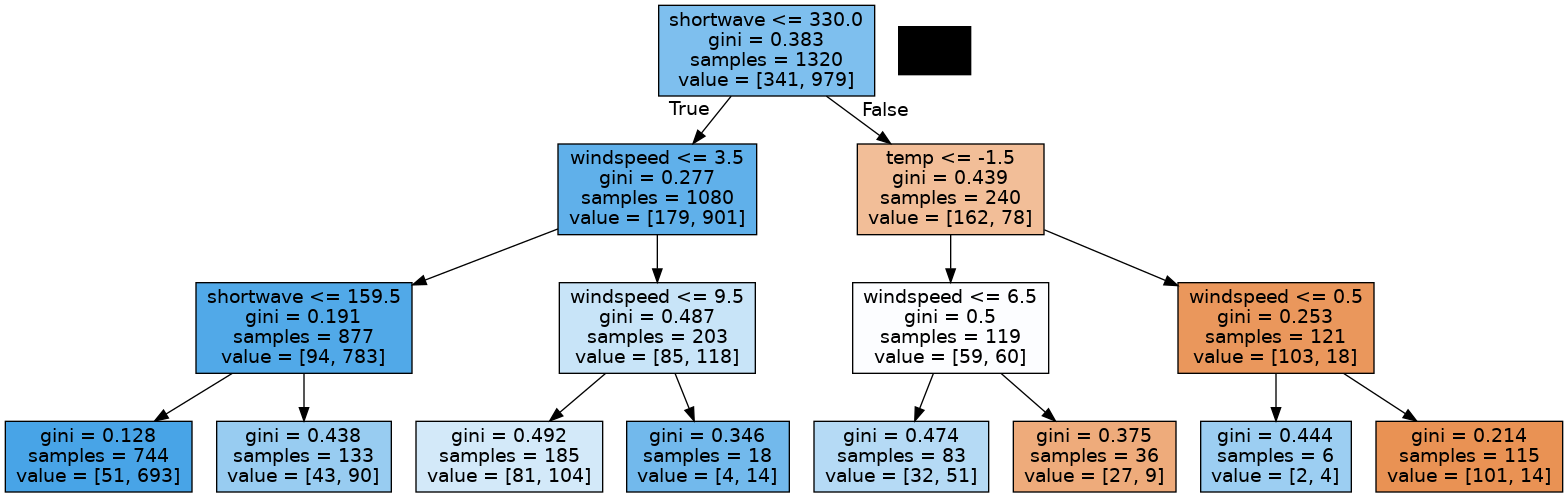

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=3)
clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
print('Accuracy on train data is %.2f' % (accuracy_score(y_train, y_pred_train)))

y_pred_test = clf.predict(X_test)
print('Accuracy on test data is %.2f' % (accuracy_score(y_test, y_pred_test)))

dot_data = tree.export_graphviz(clf, feature_names=X.columns, filled=True, 
                                out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

## Now, Random Forest

In [44]:
number_model_runs = 500 # for all random forest runs 

In [45]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=0)

parameters = {'n_estimators': [number_model_runs], 'max_depth':[3]} 
clf1 = GridSearchCV(ensemble.RandomForestClassifier(n_jobs=15), parameters) 

# trying to write it like this to get the n_jobs parameter to work 
# clf1  = ensemble.RandomForestClassifier(n_estimators=30, max_depth=3, n_jobs=4)

clf1.fit(X=X_train1,y=y_train1.values.ravel())
tree_model1 = clf1.best_estimator_ # only the GridSearchCV has the object "best_estimator_"

y_pred_train1 = tree_model1.predict(X_train1)
y_pred_test1 = tree_model1.predict(X_test1)
print('Accuracy on training data is %.2f' % (accuracy_score(y_train1, y_pred_train1)))
print('Accuracy on test data is %.2f' % (accuracy_score(y_test1, y_pred_test1)))
print(clf1.best_params_)

Accuracy on training data is 0.83
Accuracy on test data is 0.84
{'max_depth': 3, 'n_estimators': 500}


In [46]:
estimatorAccuracy=[]
for curEstimator in range(number_model_runs):
    estimatorAccuracy.append([curEstimator,accuracy_score(y.values, tree_model1.estimators_[curEstimator].predict(X.values))])

estimatorAccuracy=pd.DataFrame(estimatorAccuracy,columns=['estimatorNumber','Accuracy'])
estimatorAccuracy.sort_values(inplace=True,by='Accuracy',ascending=False)

bestDecisionTree1= tree_model1.estimators_[estimatorAccuracy.head(1)['estimatorNumber'].values[0]]

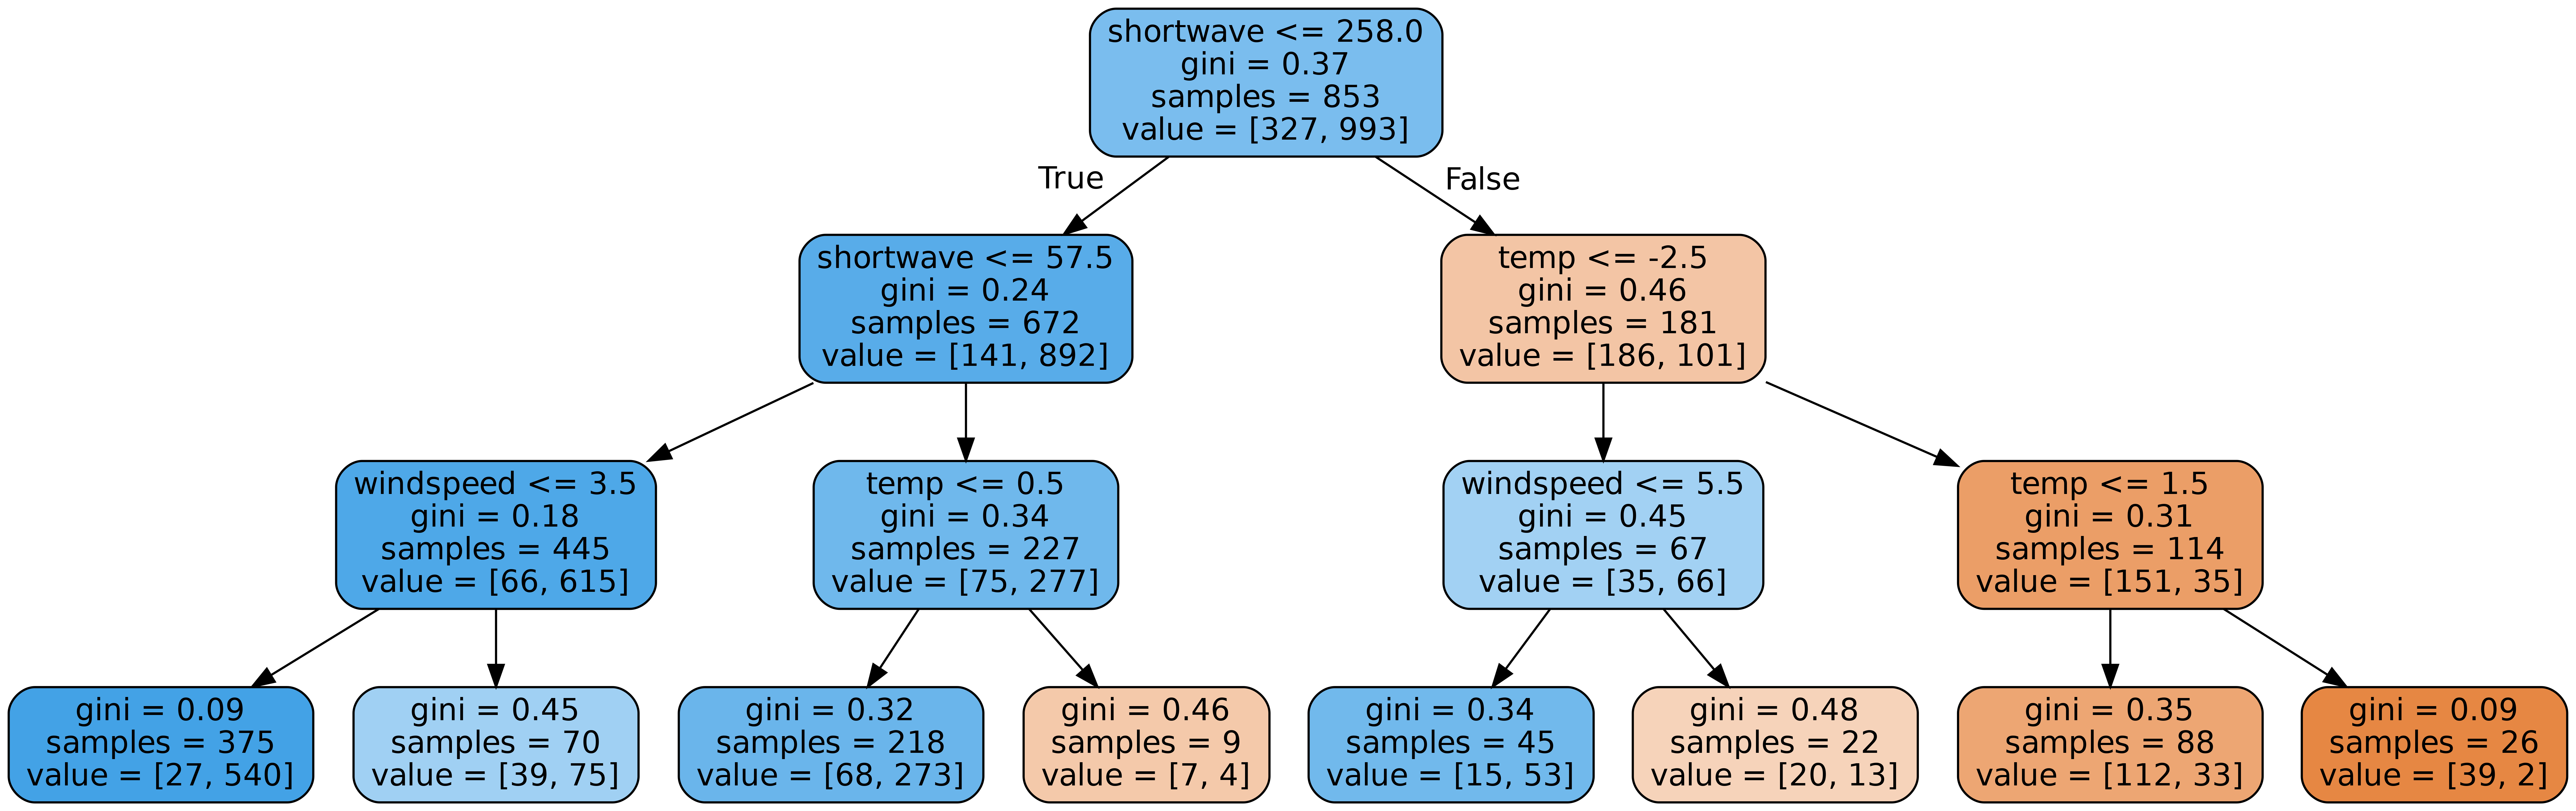

In [47]:
tree.export_graphviz(bestDecisionTree1, out_file='ensemble_tree1.dot', 
                feature_names = X.columns,
                # class_names = ('no_veg', 'veg'),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'ensemble_tree1.dot', '-o', 'ensemble_tree1.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'ensemble_tree1.png')

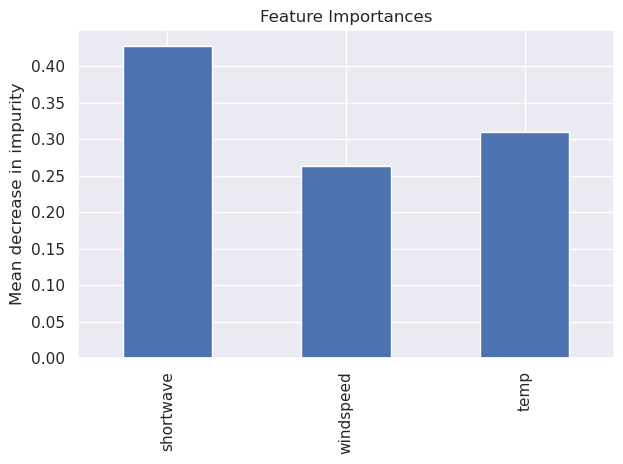

In [48]:
# Feature Importance 
importances1 = tree_model1.feature_importances_
std1 = np.std([tree_model1.feature_importances_ for tree in tree_model1.estimators_], axis=0)

forest_importances1 = pd.Series(importances1, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances1.plot.bar(yerr=std1, ax=ax)
ax.set_title("Feature Importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()